# JetSeT - Adding multiple emission components

#### This notebook shows how to include <u>multiple emission components</u> to a leptonic model.<br> 

#### In our example motivate the necessity of multiple emitting zones by showing that <u>radio fluxes are self-absorbed</u> in the compact region responsible for the X-ray & gamma-ray flux.

#### The self-asborption effect in the radio band is commonly dubbed as <u>Synchrotron Self-Absorption</u>, SSA

In [1]:
import matplotlib.pylab as plt
import numpy as np

import jetset
from jetset.jet_model import Jet
from jetset.data_loader import ObsData, Data
from jetset.plot_sedfit import PlotSED
from jetset.sed_shaper import SEDShape
from jetset.obs_constrain import ObsConstrain
from jetset.minimizer import ModelMinimizer
from jetset.model_manager import FitModel
print (jetset.__version__)
from jetset.mcmc import McmcSampler


1.3.0


For this example, we will use the broadband SED of Mrk421 published in [Abdo et al. 2011 ApJ, 736, 131](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract). This SED is very well sampled, in particular in the radio band, thus ideal for this exercise.

### Load data

In [2]:
filename = './data/Mrk421_MW2009_SED.txt'

d = np.genfromtxt(filename)

freq = d[:,0]
nufnu = d[:,1]
nufnu_err = d[:,2]

We still did not talk about systematics... althought they should be considered when fitting data from multiple instruments. This is a complexe "business", but for the sake of simplicity, we can include systematics by manually modifying the uncertainty array. For this exercise, let's consider a 15% systematic uncertainty:


In [3]:
nufnu_err += 0.15*nufnu

In [4]:
data = Data(n_rows=d.shape[0])
data.set_field('x',freq)
data.set_field('y',nufnu)
data.set_field('dy',nufnu_err)
data.set_meta_data('z',0.03)#set redshift of the source, here it is Mrk421 so z=0.03
data.set_meta_data('obj_name', 'Mrk421')
print(data.table)

     x        dx       y                 dy           ... T_stop   UL  data_set
     Hz       Hz erg / (s cm2)     erg / (s cm2)      ...  MJD                 
------------ --- ------------- ---------------------- ... ------ ----- --------
2299540000.0 0.0    1.3409e-14 2.4023499999999997e-15 ...    0.0 False      0.0
2639697000.0 0.0  1.793088e-14 2.6896320000323113e-15 ...    0.0 False      0.0
4799040000.0 0.0    2.3136e-14             3.7104e-15 ...    0.0 False      0.0
4805039000.0 0.0  1.773414e-14           4.433535e-15 ...    0.0 False      0.0
4843552000.0 0.0   2.77614e-14  4.164210000026153e-15 ...    0.0 False      0.0
7698460000.0 0.0     3.696e-14              6.006e-15 ...    0.0 False      0.0
         ... ...           ...                    ... ...    ...   ...      ...
6.073707e+25 0.0   1.14705e-10           8.294271e-11 ...    0.0 False      0.0
9.603433e+25 0.0  4.662219e-11 1.2091240499999999e-11 ...    0.0 False      0.0
1.522041e+26 0.0  5.221583e-11 1.2723004

### Plot SED

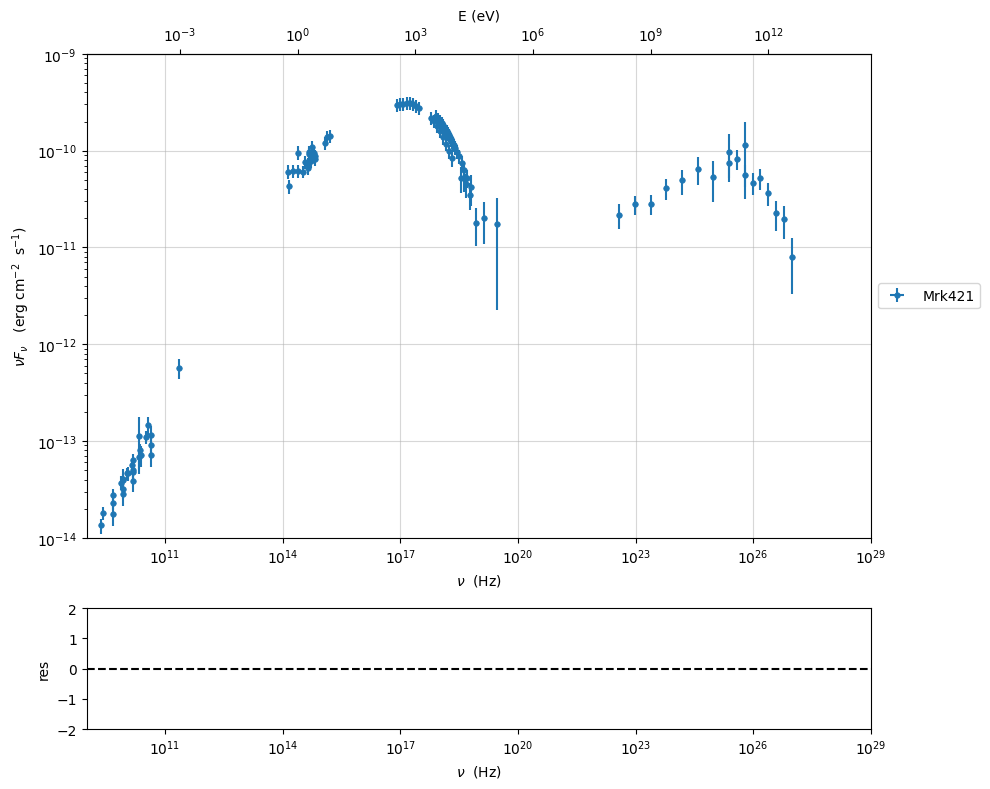

In [5]:
sed_data = ObsData(data_table=data)
sed_plot = sed_data.plot_sed()
sed_plot.setlim(y_min=1e-14,y_max=1e-9,x_min=1e9,x_max=1e29)

Before diving into the study of SSA effects, let's first recall that the characteristic frequency at which absorption becomes significant has the following dependency on $B$, $R$ and $N_{\rm tot}$ (the total number of particles):

<div align="center">
$$
\nu_{\rm SSA} \propto \left( B ^{\frac{p+2}{2}} \frac{N_{\rm tot}}{R^2} \right)^{\frac{2}{p+4}}
$$
</div>

Here, $p$ is the power-law slope of the electron dominating in the radio band.

Let's now investigate the effect of $R$ on $\nu_{\rm SSA}$. For this example, we use a broken power-law electron distribution and parameter values for the emitting region that are typical of blazars.

In [6]:
my_jet=Jet(name='SSC_Model', electron_distribution='bkn')

#fixing some parameters
my_jet.set_par('B', val=5e-1)
my_jet.set_par('beam_obj', val=20)
my_jet.set_par('z_cosm', val=0.03)

my_jet.set_par('gmin', val=1e0)
my_jet.set_par('gmax', val=4e5)
my_jet.set_par('gamma_break', val=0.8e5)
my_jet.set_par('p', val=2.4)
my_jet.set_par('p_1', val=4)
my_jet.set_par('N', val=4.2e-1)

===> setting C threads to 8


At this point, it is important to make sure that SSA is enabled (by default, it is the case)

In [7]:
my_jet.spectral_components.Sync.state='self-abs'

We scan now over several values for $R$

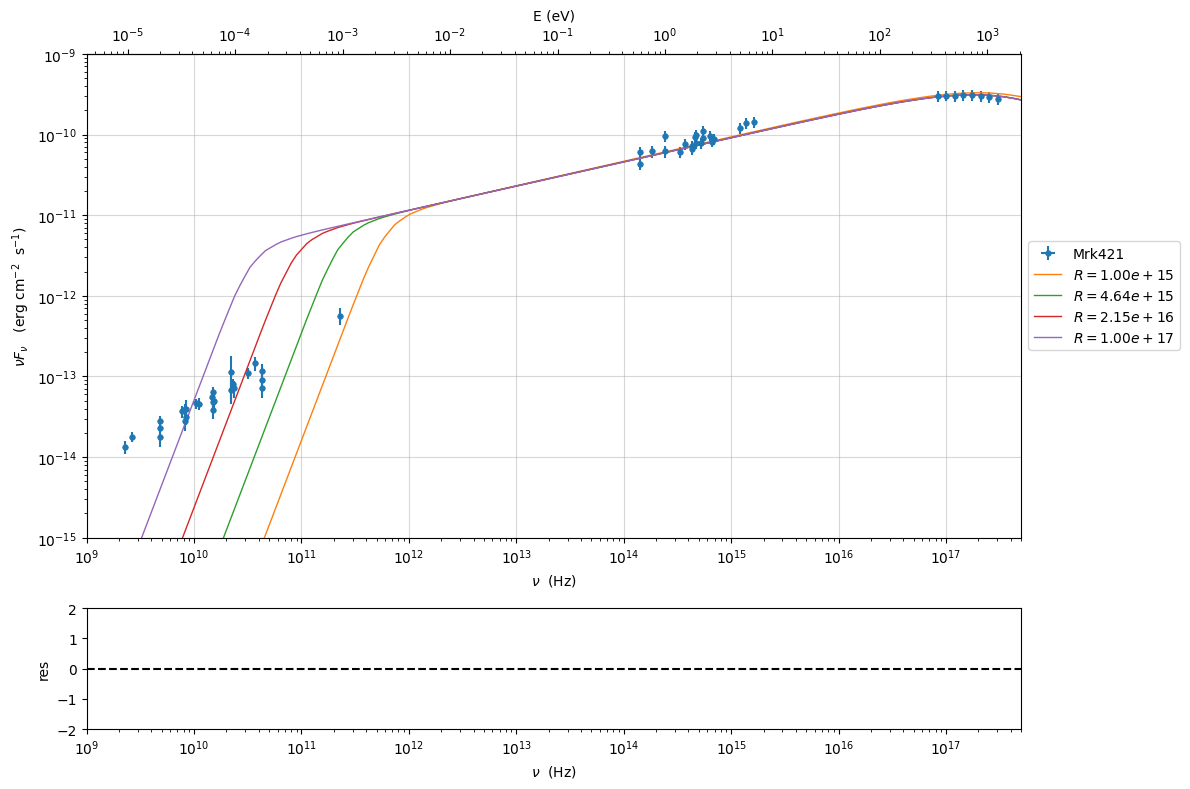

In [8]:
R_scanned_values = np.geomspace(1e15, 1e17, 4)

#create plotting object
R_scan=PlotSED(sed_data=sed_data)

for R in R_scanned_values:
    my_jet.set_par('R',val=R)
    
    #We adjust the particle density such that the synchrotron flux remains at nuFnu_obs=3e-10 erg/cm2/s at the frequency nu=1e17 Hz.
    my_jet.set_N_from_nuFnu(nuFnu_obs=3e-10,nu_obs=1e17)
    my_jet.eval()
  
    my_jet.plot_model(plot_obj=R_scan,label=fr'$R={R:.2e}$',comp='Sum')
    R_scan.setlim(y_min=1e-15,y_max=1e-9,x_min=1e9,x_max=5e17)

We already see that even for relatively large emitting region $R \sim 1e17$ cm, the radio fluxes are significantly absorbed at $\nu \sim 10^9$ Hz.<br>
*Note: the electron distribution starts from $\gamma_{\rm min}=1$, so the cut-off is not related to  $\gamma_{\rm min}$, but really due to absorption effects.*

Keep in mind that blazars are variable on $\sim$hour timescale in the X-ray and VHE. This implies an emitting region in the order of (due to causality argument):
<div align="center">
$$
R \sim \delta \; c \; \Delta T_{\rm var, obs}
$$
</div>

And one gets $R \sim 10^{15-16}$ cm assuming $\delta \approx 20$ and $\Delta T_{\rm var, obs}\sim 1$ hr. 

Let's now see the effect under $B$ variations:

===> setting C threads to 8


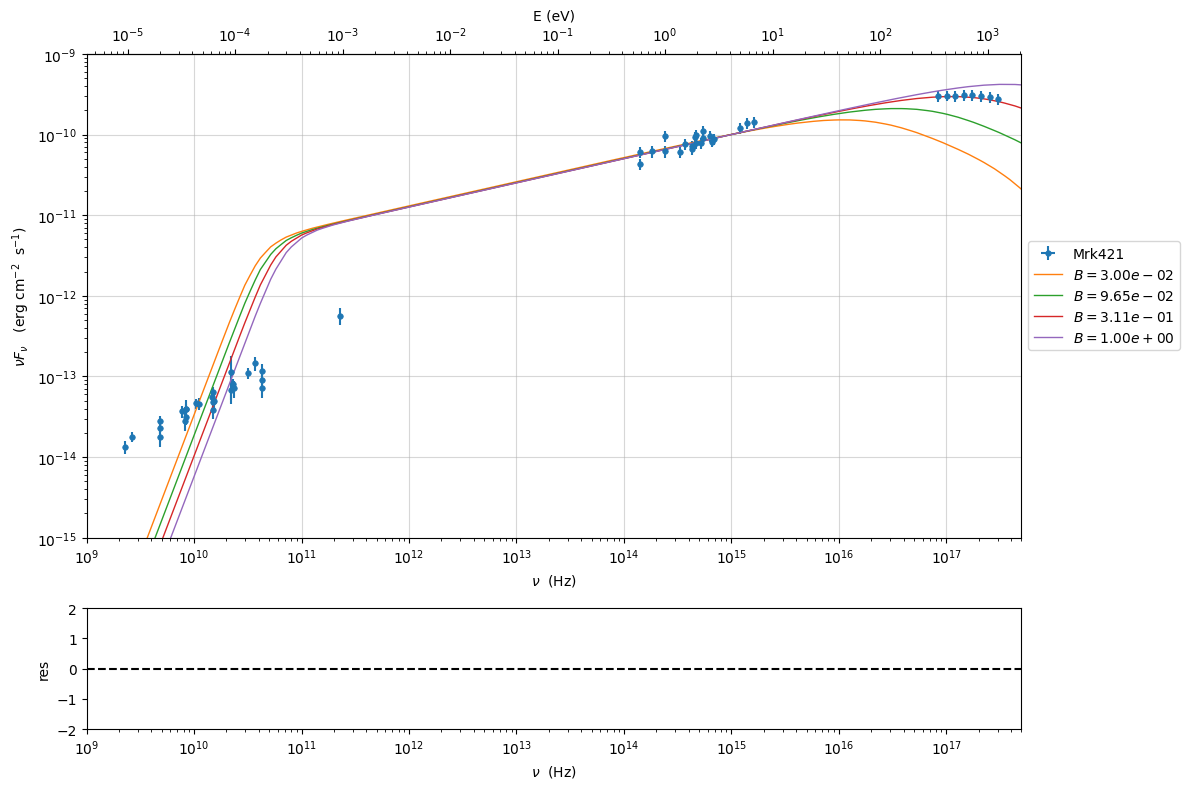

In [9]:
my_jet=Jet(name='SSC_Model', electron_distribution='bkn')

#fixing some parameters
my_jet.set_par('beam_obj', val=20)
my_jet.set_par('z_cosm', val=0.03)
my_jet.set_par('R', val=4e16)

my_jet.set_par('gmin',val=1e0)
my_jet.set_par('gmax',val=4e5)
my_jet.set_par('gamma_break',val=0.8e5)
my_jet.set_par('p',val=2.4)
my_jet.set_par('p_1',val=4)

my_jet.spectral_components.Sync.state='self-abs'

B_scanned_values = np.geomspace(0.03, 1, 4)

#create plotting object
B_scan=PlotSED(sed_data=sed_data)

for B in B_scanned_values:
    my_jet.set_par('B',val=B)
    my_jet.set_N_from_nuFnu(nuFnu_obs=1e-10,nu_obs=1e15)
    my_jet.eval()

    my_jet.plot_model(plot_obj=B_scan,label=fr'$B={B:.2e}$',comp='Sum')
    B_scan.setlim(y_min=1e-15,y_max=1e-9,x_min=1e9,x_max=5e17)


*Note: In the plot above, the shifts in $\nu_{\rm SSA}$ are less pronounced than under $R$-only changes. The reason is that to keep the synchrotron flux at a similar level, we modified the value of $N$ using `my_jet.set_N_from_nuFnu()`. Since for a constant synchrotron flux $B$ & $N$ are anti-correlated, the evolution of $\nu_{\rm SSA}$ is somewhat reduced since $\nu_{\rm SSA} \propto B ^{\frac{p+2}{p+4}} \; N_{\rm tot}^{\frac{2}{p+4}}$* (see equation above).

In any case, those illustrative cases show the difficulty of 1-zone SSC models to explain radio and X-ray/TeV fluxes simultaneously. In what follows, we therefore introduce a second emitting component that dominate the radio band. 

**Exercise**: Try to use the fitting routines of JetSeT to fit an SED all the way from radio frequencies to TeV energies. This will convince yourself about the statement made above :)

We now setup a **model with two components**: a **compact zone**, filled with freshly accelerated electrons, that dominates the radiation starting from optical frequencies. Then, an **extended zone**, filled with "low-energy" electrons, contributes to the radio band. **The larger size of the extended zone will limit SSA effects**.

In [10]:
#Define a jet instance
compact_zone = Jet(name='compact_zone', electron_distribution='bkn')
fit_model = FitModel(jet=compact_zone, name='SSC-twozone',template=None)

fit_model.freeze(compact_zone,'z_cosm')
fit_model.compact_zone.parameters.z_cosm.val=0.03 

fit_model.freeze(compact_zone,'beam_obj')
fit_model.compact_zone.parameters.beam_obj.val=20

fit_model.freeze(compact_zone,'gmax')
fit_model.compact_zone.parameters.gmax.val=1e6

fit_model.freeze(compact_zone,'gmin')
fit_model.compact_zone.parameters.gmin.val=1e3

#Define some starting values for the free parameters and fitting ranges
fit_model.compact_zone.parameters.R.val=4e16
fit_model.compact_zone.parameters.R.fit_range=[1e15,1e17]

fit_model.compact_zone.parameters.B.val=1e-1
fit_model.compact_zone.parameters.B.fit_range=[1e-3,1e0]

fit_model.compact_zone.parameters.gamma_break.val=1e5
fit_model.compact_zone.parameters.gamma_break.fit_range=[1e4,1e6]

fit_model.compact_zone.parameters.p.val=2.4
fit_model.compact_zone.parameters.p.fit_range=[1, 4]

fit_model.compact_zone.parameters.p_1.val=3.4
fit_model.compact_zone.parameters.p_1.fit_range=[1, 4]


===> setting C threads to 8


/home/axel/anaconda3/envs/jetset/lib/python3.10/site-packages/jetset/model_manager.py:158: UserWarning: no cosmology defined, using the one from jet FlatLambdaCDM(name="Planck13", H0=67.77 km / (Mpc s), Om0=0.30712, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.048252)
  warnings.warn(m)


We then define the `Jet` object for the extended zone. Here, we use a simple power-law electron distribution with `electron_distribution='pl'` (to limit the number of free parameters of the model).

In [11]:
extended_zone = Jet(name='extended_zone', electron_distribution='pl')

===> setting C threads to 8


The second component can then be added by passing it to the `add_component()` method of the `fit_model` object

In [12]:
fit_model.add_component(extended_zone)

And we fix some of the parameters, and we will only fit the power-law slope, $B$ and $N$. We arbitrarily limit the electron distribution to $\gamma_{\rm max}$ to $10^4$ to make the `extended_zone` subdominant in the optical frequencies. Also, we set $R$ to $10^{18}$ cm (~pc scale radio emission) and $\delta_{extended}=10$ in light with pc-scale kinematic studies of BL Lac jets (see [Jorstad et al., 2017, ApJ, 846, 98](https://ui.adsabs.harvard.edu/abs/2017ApJ...846...98J/abstract)).

In [13]:
#add second zone, the one responsible for the radio emission:
fit_model.freeze(extended_zone,'z_cosm')
fit_model.extended_zone.parameters.z_cosm.val=0.03 

fit_model.freeze(extended_zone,'beam_obj')
fit_model.extended_zone.parameters.beam_obj.val=10

fit_model.freeze(extended_zone,'gmax')
fit_model.extended_zone.parameters.gmax.val=1e4

fit_model.freeze(extended_zone,'gmin')
fit_model.extended_zone.parameters.gmin.val=1e0

#we fixed the zone radius to 1e18 cm
fit_model.freeze(extended_zone,'R')
fit_model.extended_zone.parameters.R.val=1e18

#Define some starting values for the free parameters and fitting ranges
fit_model.extended_zone.parameters.B.val=1e-1
fit_model.extended_zone.parameters.B.fit_range=[1e-3,1e0]

fit_model.extended_zone.parameters.p.val=2.4
fit_model.extended_zone.parameters.p.fit_range=[1.5, 3]

We can now fit the "multi-component" model, from $10^8$ Hz to $10^{28}$Hz!

In [14]:
#fit the two component model
model_minimizer = ModelMinimizer('lsb')
best_fit_lsb = model_minimizer.fit(fit_model,sed_data,1e8,1e28,fitname='SSC-best-fit',repeat=3,silent=True)

#and now with the minuit minimize
model_minuit_minimizer = ModelMinimizer('minuit')
best_fit_minuit = model_minuit_minimizer.fit(fit_model,sed_data,1e8,1e28,fitname='SSC-best-fit',repeat=3, silent=True)


====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad


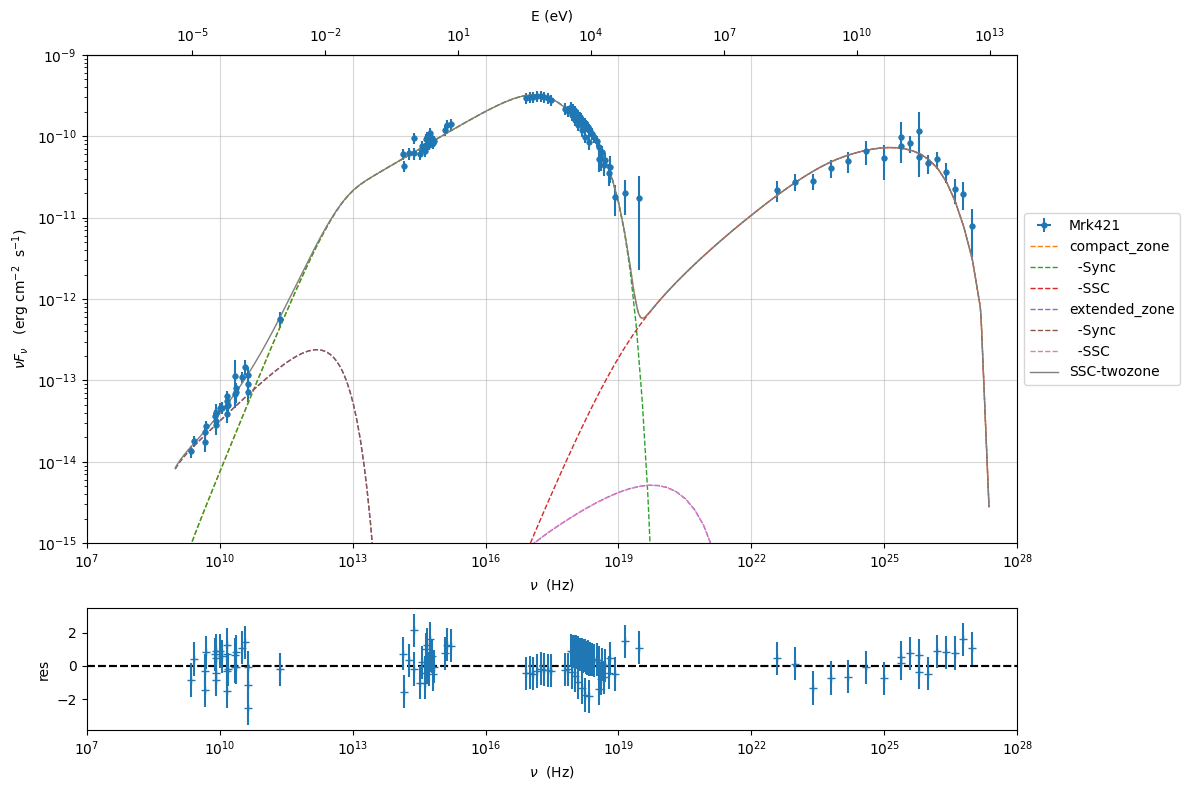

In [15]:
fit_model.set_nu_grid(1E9,5E28,1500)
fit_model.eval()
plot=fit_model.plot_model(sed_data=sed_data)
plot.setlim(x_min=1e7, x_max=1e28, y_min=1e-15, y_max=1e-9)

We check the convergence and the fit results:

In [16]:
best_fit_minuit.success

True

In [17]:
fit_model.show_pars()

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
compact_zone,R,region_size,cm,3.881181e+16,1.000000e+03,1.000000e+30,False,False
compact_zone,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
compact_zone,B,magnetic_field,gauss,5.360694e-02,0.000000e+00,--,False,False
compact_zone,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
compact_zone,beam_obj,beaming,,2.000000e+01,1.000000e-04,--,False,True
compact_zone,z_cosm,redshift,,3.000000e-02,0.000000e+00,--,False,True
compact_zone,gmin,low-energy-cut-off,lorentz-factor*,1.000000e+03,1.000000e+00,1.000000e+09,False,True
compact_zone,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,True
compact_zone,N,emitters_density,1 / cm3,4.083371e-01,0.000000e+00,--,False,False
compact_zone,gamma_break,turn-over-energy,lorentz-factor*,1.931758e+05,1.000000e+00,1.000000e+09,False,False


#### Linking parameters between two `Jet` instances

In the example above, the parameters of the `extended` zone are completely independent from the ones of the `compact` zone. In reality, this may not be totally true. We may imagine a situation where particles are first accelerated, then radiate in the `compact` zone, and subsequently strem in the `extended`zone. <br>
In this hypothetical (but plausible) scenario, the particles entering in the `extended` should have an index `p` equal to the one of the `compact` zone (below the cooling break).<br>


In JetSeT, there is a way to link parameters between two `Jet` instance:

In [18]:
linked_pars=['p']
for par in linked_pars:
    fit_model.link_par(par_name=par, from_model='compact_zone', to_model='extended_zone')


adding par: p to  p


And we can now re-run the fit:

In [ ]:
#fit the two component model
model_minimizer = ModelMinimizer('lsb')
best_fit_lsb = model_minimizer.fit(fit_model,sed_data,1e8,1e28,fitname='SSC-best-fit',repeat=3,silent=True)

#and now with the minuit minimize
model_minuit_minimizer = ModelMinimizer('minuit')
best_fit_minuit = model_minuit_minimizer.fit(fit_model,sed_data,1e8,1e28,fitname='SSC-best-fit',repeat=3, silent=True)


====> simplex
====> migrad
====> simplex
====> migrad


In [ ]:
best_fit_minuit.success

In [ ]:
fit_model.show_pars()

In [ ]:
fit_model.set_nu_grid(1E9,5E28,1500)
fit_model.eval()
plot=fit_model.plot_model(sed_data=sed_data)
plot.setlim(x_min=1e7, x_max=1e28, y_min=1e-15, y_max=1e-9)